In [18]:
# instantiate Saturn cluster
from dask_saturn import SaturnCluster
cluster = SaturnCluster()
cluster

In [20]:
cluster.scale(10)

In [21]:
from dask.distributed import Client

client = Client(cluster)
client

Client Scheduler: tcp://danroth-myjupyter-dask.main-namespace:8786 Dashboard: https://danroth-myjupyter-dask.internal.saturnenterprise.io,Cluster Workers: 10 Cores: 10 Memory: 635.00 GB


In [22]:
import dask.dataframe as dd
ecom_df = dd.read_csv('s3://e-commerce-explore/2019-Oct.csv', storage_options={'anon': True})
ecom_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [8]:
ecom_df.event_type.value_counts().compute()

view        40779399
cart          926516
purchase      742849
Name: event_type, dtype: int64

In [39]:
!pip install seaborn

  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)


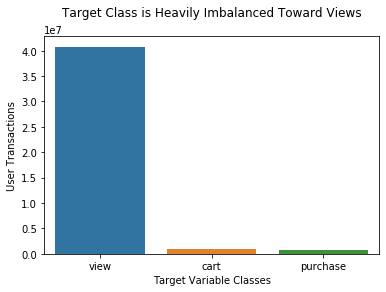

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(x = ['view', 'cart', 'purchase'], y = [40779399, 926516, 742849])
ax.set_title('Target Class is Heavily Imbalanced Toward Views', pad=20)
plt.xlabel('Target Variable Classes')
plt.ylabel('User Transactions');

In [23]:
#feature transformations
ecom_df.event_time = dd.to_datetime(ecom_df.event_time)
ecom_df['date'] = dd.to_datetime(ecom_df.event_time.dt.date)
ecom_df['hour'] = ecom_df.event_time.dt.round('H').dt.hour
ecom_df['weekday'] = ecom_df.event_time.dt.weekday
ecom_df.category_code = ecom_df.category_code.fillna('unknown')
ecom_df.brand = ecom_df.brand.fillna('unknown')

ecom_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,hour,weekday
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,unknown,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,0,1
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,0,1
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,unknown,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,0,1
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,0,1
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,0,1


In [24]:
import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import DummyEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [25]:
drop = ['event_time', 'event_type', 'category_code', 'user_session', 'date']
ecom_df_feat = ecom_df.drop(drop, axis=1)
ecom_df_feat.head()

,product_id,category_id,brand,price,user_id,hour,weekday
0,44600062,2103807459595387724,shiseido,35.79,541312140,0,1
1,3900821,2053013552326770905,aqua,33.20,554748717,0,1
2,17200506,2053013559792632471,unknown,543.10,519107250,0,1
3,1307067,2053013558920217191,lenovo,251.74,550050854,0,1
4,1004237,2053013555631882655,apple,1081.98,535871217,0,1


In [26]:
de = DummyEncoder()
ecom_df_feat = ecom_df_feat.categorize(columns = ['brand'])
ecom_df_trn = de.fit_transform(ecom_df_feat)
ecom_df_trn.head()

,product_id,category_id,price,user_id,hour,weekday,brand_shiseido,brand_aqua,brand_unknown,brand_lenovo,...,brand_vorson,brand_livdelano,brand_mastela,brand_svoboda,brand_acorp,brand_naturakamchatka,brand_milk,brand_ecolaboratorie,brand_organicshop,brand_skindoctors
0,44600062,2103807459595387724,35.79,541312140,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3900821,2053013552326770905,33.20,554748717,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17200506,2053013559792632471,543.10,519107250,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1307067,2053013558920217191,251.74,550050854,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1004237,2053013555631882655,1081.98,535871217,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#train/test split
X = ecom_df_trn[['price', 'hour', 'weekday', 'product_id', 'category_id', 'user_id']]
y = ecom_df.event_type.replace('view', 0).replace('cart', 1).replace('purchase', 2).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, convert_mixed_types=True)

In [28]:
log = LogisticRegression()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier(n_estimators=10)

In [12]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
log_pred = log.predict(X_test)
print(classification_report(y_test, log_pred, labels=[0,1,2]))

/opt/conda/envs/saturn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98   8158421
           1       0.00      0.00      0.00    185145
           2       0.00      0.00      0.00    148374

    accuracy                           0.96   8491940
   macro avg       0.32      0.33      0.33   8491940
weighted avg       0.92      0.96      0.94   8491940



In [12]:
y_prob = log.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.535192 (macro),
0.551795 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.552786 (macro),
0.554937 (weighted by prevalence)


In [29]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
tree_pred = tree.predict(X_test)
print(classification_report(y_test, tree_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   8158421
           1       0.57      0.00      0.00    185145
           2       0.00      0.00      0.00    148374

    accuracy                           0.96   8491940
   macro avg       0.51      0.33      0.33   8491940
weighted avg       0.94      0.96      0.94   8491940



In [15]:
y_prob = tree.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.667959 (macro),
0.735016 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.739094 (macro),
0.744061 (weighted by prevalence)


In [10]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
forest_pred = forest.predict(X_test)
print(classification_report(y_test, forest_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   8158421
           1       0.57      0.00      0.00    185145
           2       0.00      0.00      0.00    148374

    accuracy                           0.96   8491940
   macro avg       0.51      0.33      0.33   8491940
weighted avg       0.94      0.96      0.94   8491940



In [16]:
y_prob = forest.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.667764 (macro),
0.734706 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.738752 (macro),
0.743818 (weighted by prevalence)


In [ ]:
tree2.fit(X_train, y_train)

In [31]:
tree2_pred = tree2.predict(X_test)
print(classification_report(y_test, tree2_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   8158421
           1       0.40      0.00      0.01    185145
           2       0.00      0.00      0.00    148374

    accuracy                           0.96   8491940
   macro avg       0.46      0.33      0.33   8491940
weighted avg       0.93      0.96      0.94   8491940



In [32]:
y_prob = tree2.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.668293 (macro),
0.737941 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.737667 (macro),
0.759454 (weighted by prevalence)


In [34]:
tree3 = DecisionTreeClassifier()
tree3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [35]:
tree3_pred = tree3.predict(X_test)
print(classification_report(y_test, tree3_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98   8158421
           1       0.22      0.13      0.16    185145
           2       0.01      0.00      0.00    148374

    accuracy                           0.95   8491940
   macro avg       0.40      0.37      0.38   8491940
weighted avg       0.93      0.95      0.94   8491940



In [37]:
y_prob = tree3.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.604168 (macro),
0.679786 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.665079 (macro),
0.742623 (weighted by prevalence)


In [46]:
#syntax for saving and loading models for later use
from joblib import dump, load

dump(tree3, 'tree3.joblib')
tree3 = load('tree3.joblib')